In [1]:
from google.colab import drive
drive.mount('/content/drive')
     

Mounted at /content/drive


In [2]:
import zipfile as zf

files = zf.ZipFile("/content/drive/MyDrive/Plant Leaf Disease Detection/archive.zip",'r')
files.extractall()
files.close()

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import keras


from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras.applications.vgg19 import VGG19,preprocess_input,decode_predictions

In [42]:
train_datagen = ImageDataGenerator(
    zoom_range=0.5, shear_range=0.3,horizontal_flip=True,preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [43]:
train = train_datagen.flow_from_directory(directory="/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",target_size=(256,256),batch_size=32)
val = val_datagen.flow_from_directory(directory="/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid",target_size=(256,256),batch_size=32)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [44]:
t_img , label=train.next()

In [45]:
t_img.shape

(32, 256, 256, 3)

In [46]:
def plotImage(img_arr,label):
    for im,l in zip(img_arr,label):
        plt.figure(figsize=(5,5))
        plt.imshow(im)
        plt.show()

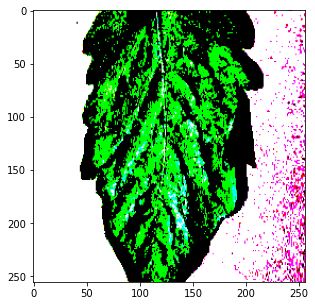

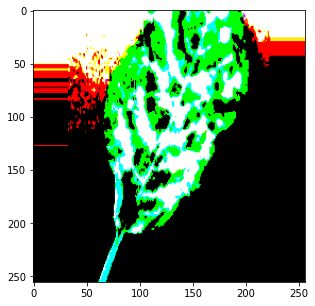

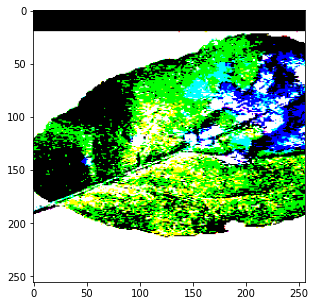

In [47]:
plotImage(t_img[:3],label[:3])

In [48]:
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.applications.vgg19 import VGG19
import keras

In [50]:
base_model = VGG19(input_shape=(256,256,3),include_top = False)

80134624/80134624 [==============================] - 5s 0us/step


In [51]:
for layer in base_model.layers:
    layer.trainable=False

In [52]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [53]:
X=Flatten()(base_model.output)

X= Dense(units=38,activation='softmax')(X)

model=Model(base_model.input,X)

In [54]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [55]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam',metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [56]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es=EarlyStopping(monitor='val_accuracy',min_delta=0.01,patience=3,verbose=1)

mc=ModelCheckpoint(filepath='best_model.h5',monitor='val_accuracy',min_delta=0.01,patience=3,verbose=1,save_best_only=True)

cb=[es,mc]

In [57]:
his = model.fit_generator(train, steps_per_epoch=16,
                          epochs=50,
                          verbose=1,
                          callbacks=cb,
                          validation_data=val,
                          validation_steps=16)

<ipython-input-57-05719c877693>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  his = model.fit_generator(train, steps_per_epoch=16,


Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 27.0478 - accuracy: 0.1934
Epoch 1: val_accuracy improved from -inf to 0.36719, saving model to best_model.h5
16/16 [==============================] - 24s 810ms/step - loss: 27.0478 - accuracy: 0.1934 - val_loss: 15.9658 - val_accuracy: 0.3672
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 13.2202 - accuracy: 0.4238
Epoch 2: val_accuracy improved from 0.36719 to 0.53125, saving model to best_model.h5
16/16 [==============================] - 13s 811ms/step - loss: 13.2202 - accuracy: 0.4238 - val_loss: 11.7847 - val_accuracy: 0.5312
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 12.0284 - accuracy: 0.5371
Epoch 3: val_accuracy improved from 0.53125 to 0.71094, saving model to best_model.h5
16/16 [==============================] - 17s 1s/step - loss: 12.0284 - accuracy: 0.5371 - val_loss: 6.5894 - val_accuracy: 0.7109
Epoch 4/50
16/16 [==============================] - ETA: 0s - 

In [58]:
h=his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

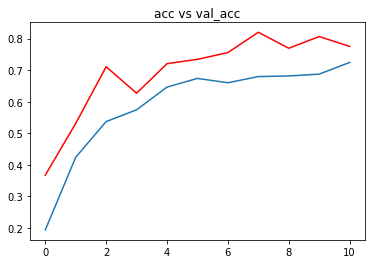

In [60]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c='red')
plt.title("acc vs val_acc")
plt.show()

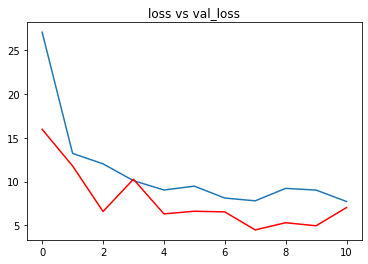

In [61]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c='red')
plt.title("loss vs val_loss")
plt.show()

In [62]:
from keras.models import load_model
model = load_model("/content/best_model.h5")

In [64]:
acc = model.evaluate_generator(val)[1]
print(f"The accuracy = {acc*100}%")

<ipython-input-64-6275e7f27a58>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = model.evaluate_generator(val)[1]


The accuracy = 76.71295404434204%


In [69]:
ref = dict(zip(list(train.class_indices.values()), list(train.class_indices.keys())))

In [70]:
def prediction(path):
    img = load_img(path,target_size=(256,256))
    i=img_to_array(img)
    im=preprocess_input(i)
    img=np.expand_dims(im,axis=0)
    pred=np.argmax(model.predict(img))
    print(ref[pred])

In [73]:
path = "/content/test/test/TomatoYellowCurlVirus1.JPG"
prediction(path)

1/1 [==============================] - 0s 75ms/step
Tomato___Tomato_mosaic_virus


In [67]:
train.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Blueberry___healthy': 4,
 'Cherry_(including_sour)___Powdery_mildew': 5,
 'Cherry_(including_sour)___healthy': 6,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7,
 'Corn_(maize)___Common_rust_': 8,
 'Corn_(maize)___Northern_Leaf_Blight': 9,
 'Corn_(maize)___healthy': 10,
 'Grape___Black_rot': 11,
 'Grape___Esca_(Black_Measles)': 12,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13,
 'Grape___healthy': 14,
 'Orange___Haunglongbing_(Citrus_greening)': 15,
 'Peach___Bacterial_spot': 16,
 'Peach___healthy': 17,
 'Pepper,_bell___Bacterial_spot': 18,
 'Pepper,_bell___healthy': 19,
 'Potato___Early_blight': 20,
 'Potato___Late_blight': 21,
 'Potato___healthy': 22,
 'Raspberry___healthy': 23,
 'Soybean___healthy': 24,
 'Squash___Powdery_mildew': 25,
 'Strawberry___Leaf_scorch': 26,
 'Strawberry___healthy': 27,
 'Tomato___Bacterial_spot': 28,
 'Tomato___Early_blight': 29,
 'Toma

In [77]:
from tensorflow.contrib import lite
converter = lite.TFLiteConverter.from_keras_model_file( 'best_model.h5' ) 
model = converter.convert()
file = open( 'output.tflite' , 'wb' ) 
file.write( model )

ModuleNotFoundError: ignored

In [80]:
pip install streamlit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.2 MB 11.5 MB/s 
     |████████████████████████████████| 4.7 MB 65.2 MB/s 
     |████████████████████████████████| 182 kB 71.8 MB/s 
     |████████████████████████████████| 164 kB 69.2 MB/s 
     |████████████████████████████████| 78 kB 8.5 MB/s 
     |████████████████████████████████| 237 kB 72.9 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 51 kB 8.2 MB/s 
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=80463337ed5ffda82dd42c56ebe271cb2fd2cc9d3fc2f982314108e32e5774a4
  Stored in directory: /root/.cache/pip/wheels/19/09/72/3eb74d236bb48bd0f3c6c3c83e4e0c5bbfcbcad7c6c3539db8
Successfully built validators


In [87]:
import torch

model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True).eval()

TypeError: ignored